In [1]:
# switch
sub_study = True
sub_image = True

DEBUG_MODE = False

In [2]:
!pip install '../input/myofflinepackage/torch-1.9.0cu102-cp37-cp37m-linux_x86_64.whl'
!pip install '../input/myofflinepackage/torchvision-0.10.0cu102-cp37-cp37m-linux_x86_64.whl'

# !pip install timm
!pip install '../input/myofflinepackage/timm-0.4.9-py3-none-any.whl'

# # !pip install ensemble-boxes
!pip install '../input/myofflinepackage/ensemble_boxes-1.0.6-py3-none-any.whl'

# !pip install python-gdcm
!pip install '../input/myofflinepackage/python_gdcm-3.0.9.0-cp37-cp37m-manylinux2014_x86_64.whl'

# # install detectron2
!pip install '../input/myofflinepackage/detectron2v0.5/importlib_resources-5.2.2-py3-none-any.whl'
!pip install '../input/myofflinepackage/detectron2v0.5/black-21.4b2-py3-none-any.whl'
!pip install '../input/myofflinepackage/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar'
!pip install '../input/myofflinepackage/detectron2v0.5/iopath-0.1.8-py3-none-any.whl'
!cp '../input/myofflinepackage/detectron2v0.5/fvcore-0.1.5.post20210804.tar.gz.tmp' './fvcore-0.1.5.post20210804.tar.gz'
!pip install './fvcore-0.1.5.post20210804.tar.gz'
!cp '../input/myofflinepackage/detectron2v0.5/antlr4-python3-runtime-4.8.tar.gz.tmp' './antlr4-python3-runtime-4.8.tar.gz'
!pip install './antlr4-python3-runtime-4.8.tar.gz'
!pip install '../input/myofflinepackage/detectron2v0.5/omegaconf-2.1.0-py3-none-any.whl'
!pip install '../input/myofflinepackage/detectron2v0.5/hydra_core-1.1.0-py3-none-any.whl'

# if DEBUG_MODE:
#     !pip install '../input/myofflinepackage/detectron2v0.5/detectron2-0.5+cpu-cp37-cp37m-linux_x86_64.whl'
# else:
#     !pip install '../input/myofflinepackage/detectron2v0.5/detectron2-0.5p1.9.0+cu102-cp37-cp37m-linux_x86_64.whl'

!pip install '../input/myofflinepackage/detectron2v0.5/detectron2-0.5p1.9.0+cu102-cp37-cp37m-linux_x86_64.whl'

Processing /kaggle/input/myofflinepackage/torch-1.9.0cu102-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.3.0 requires torch<1.8,>=1.7.0, but you have torch 1.9.0+cu102 which is incompatible.
allennlp 2.3.0 requires torch<1.9.0,>=1.6.0, but you have torch 1.9.0+cu102 which is incompatible.
Processing /kaggle/input/myofflinepackage/torchvision-0.10.0cu102-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.1
    Uninstalling torchvision-0.8.1:
      Successfully uninstalled torchvision-0.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the s

In [3]:
# note
# fix_cv 

In [4]:
import numpy as np
import pandas as pd
from glob import glob
from collections import defaultdict, Counter
import shutil
from pathlib import Path

import ast
import cv2
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.bbox_utils import convert_bbox_to_albumentations, convert_bbox_from_albumentations

import torch
import torch.nn as nn
# from torch import nn
import torch.nn.functional as F
import torch.optim as optim
# from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
import timm
from ensemble_boxes import *
from timm.models.efficientnet import *
# import ttach as tta

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
# from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import random
import sys
import re
import os
import warnings
import gc
import time
from datetime import datetime, timedelta
from fastprogress.fastprogress import master_bar, progress_bar
from tqdm.notebook import trange, tqdm
# from torchinfo import summary

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 25)

# %load_ext line_profiler

In [5]:
print(torch.__version__)

1.9.0+cu102


In [6]:
print(torchvision.__version__)

0.10.0+cu102


In [7]:
config = {
    'batch_size': 8,
    'seed': 42,
    'num_classes': 4,
    'fold': 5,
    'image_size': 640,
    'num_workers': 4,
#     'conf_thres': 0.001,
    'iou_thres': 0.5,
    'skip_box_thr': 0.0,
    'ensemble_method': 'wbf', # [wbf, nms]
    'box_format': 'pascal_voc',
    'effnet_model_name': tf_efficientnet_b7_ns,
    'aux_loss': True,
}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
effnet_checkpoint_path_list = [
    '../input/offlinemodeldependency/effnetb7_ns_3losses_mish/effnetb7_ns_3losses_mish/fold_0/best-score.pth',
    '../input/offlinemodeldependency/effnetb7_ns_3losses_mish/effnetb7_ns_3losses_mish/fold_1/best-score.pth',
    '../input/offlinemodeldependency/effnetb7_ns_3losses_mish/effnetb7_ns_3losses_mish/fold_2/best-score.pth',
    '../input/offlinemodeldependency/effnetb7_ns_3losses_mish/effnetb7_ns_3losses_mish/fold_3/best-score.pth',
    '../input/offlinemodeldependency/effnetb7_ns_3losses_mish/effnetb7_ns_3losses_mish/fold_4/best-score.pth',
]

yolov5_checkpoint_path_list = [
    [
        '../input/offlinemodeldependency/yolov5m6_neg_640px/yolov5m6_neg_640px/f0_yolov5m6_neg_640px-best.pt', # 0.54 @ 0.192
        '../input/offlinemodeldependency/yolov5m6_neg_640px/yolov5m6_neg_640px/f1_yolov5m6_neg_640px-best.pt', # 0.57 @ 0.200
        '../input/offlinemodeldependency/yolov5m6_neg_640px/yolov5m6_neg_640px/f2_yolov5m6_neg_640px-best.pt', # 0.56 @ 0.263
        '../input/offlinemodeldependency/yolov5m6_neg_640px/yolov5m6_neg_640px/f3_yolov5m6_neg_640px-best.pt', # 0.55 @ 0.205
        '../input/offlinemodeldependency/yolov5m6_neg_640px/yolov5m6_neg_640px/f4_yolov5m6_neg_640px-best.pt', # 0.56 @ 0.229
    ],
#     [
# #         '../input/offlinemodeldependency/yolov5m6_mixup05_64_px/yolov5m6_mixup05_64_px/f0_yolov5m6_mixup05_640px-best.pt', # 0.52 @ 0.220
#         '../input/offlinemodeldependency/yolov5m6_mixup05_64_px/yolov5m6_mixup05_64_px/f1_yolov5m6_mixup05_640px-best.pt', # 0.54 @ 0.217
#     ]
]

detectron2_checkpoint_path_list = [
#     '../input/detectron2-model/centernet2/centernet2/DCN-r2-101-BiFPN/model_final_f0_centernet2_BiFPN_Haug.pth',
#     '../input/detectron2-model/centernet2/centernet2/DCN-r2-101-BiFPN/model_final_f1_centernet2_BiFPN_Haug.pth',
#     '../input/detectron2-model/centernet2/centernet2/DCN-r2-101-BiFPN/model_final_f2_centernet2_BiFPN_Haug.pth',
#     '../input/detectron2-model/centernet2/centernet2/DCN-r2-101-BiFPN/model_final_f3_centernet2_BiFPN_Haug.pth', 
    '../input/detectron2-model/centernet2/centernet2/DCN-r2-101-BiFPN/model_final_f4_centernet2_BiFPN_Haug.pth',# preferred
#     '../input/detectron2-model/frcnn-x101/frcnn-x101/model_final_f0_frcnn-x101.pth', # for debug in cpu mode
#     '../input/detectron2-model/frcnn-x101/frcnn-x101/model_final_f1_frcnn-x101.pth',
]

conf_thres_list = [
    [
        0.001,
        0.001,
        0.001,
        0.001,
        0.001, 
    ],
#     [
#         0.001,
#         0.001,
#     ],
]


In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(config['seed'])

In [10]:
SAMP_SUB = '../input/siim-covid19-detection/sample_submission.csv'
TRAIN_IMAGE_LEVEL = '../input/siim-covid19-detection/train_image_level.csv'
TRAIN_STUDY_LEVEL = '../input/siim-covid19-detection/train_study_level.csv'

TRAIN_PATH = '../input/siim-covid19-detection/train'
TEST_PATH = '../input/siim-covid19-detection/test'

TDF_PATH = '../input/siim-train-df/train_df.csv'
META = '../input/siim-train-df/meta.csv'


TRAIN_DFV3 = '../input/siim-train-df/train_df_v3.csv'

In [11]:
samp_sub = pd.read_csv(SAMP_SUB)
samp_sub

,id,PredictionString
0,00188a671292_study,negative 1 0 0 1 1
1,004bd59708be_study,negative 1 0 0 1 1
2,00508faccd39_study,negative 1 0 0 1 1
3,006486aa80b2_study,negative 1 0 0 1 1
4,00655178fdfc_study,negative 1 0 0 1 1
...,...,...
2472,46719b856de1_image,none 1 0 0 1 1
2473,31c07523a69a_image,none 1 0 0 1 1
2474,f77d7d1aebab_image,none 1 0 0 1 1
2475,ccc5b63ca96d_image,none 1 0 0 1 1


In [12]:
test_path = pd.Series(glob(fr'{TEST_PATH}/*/*/*.dcm'), name='test_path')
test_image = test_path.str.extract(fr'{TEST_PATH}/.*/.*/(.*).dcm')
test_image.columns = ['ImageInstanceUID']
test_study = test_path.str.extract(fr'{TEST_PATH}/(.*)/.*/.*.dcm')
test_study.columns = ['StudyInstanceUID']
test_df = pd.concat([test_study, test_image, test_path], axis=1)

test_df

,StudyInstanceUID,ImageInstanceUID,test_path
0,2fb11712bc93,a29c5a68b07b,../input/siim-covid19-detection/test/2fb11712b...
1,19c66935e737,9850b5470fd6,../input/siim-covid19-detection/test/19c66935e...
2,2fc50bf199cd,8d6dea06a032,../input/siim-covid19-detection/test/2fc50bf19...
3,97c5d6eb413d,dfc5c09a50bc,../input/siim-covid19-detection/test/97c5d6eb4...
4,593c3f815635,7230234e120a,../input/siim-covid19-detection/test/593c3f815...
...,...,...,...
1258,b12d2e5c39b7,a43200bd5ceb,../input/siim-covid19-detection/test/b12d2e5c3...
1259,6484393291ea,37bf83df1b86,../input/siim-covid19-detection/test/648439329...
1260,6484393291ea,b30d2aef985f,../input/siim-covid19-detection/test/648439329...
1261,531aa20ff7c3,a37a362df0ac,../input/siim-covid19-detection/test/531aa20ff...


# TestDataset

In [13]:
class TestDataset(Dataset):
    def __init__(self, df, transforms=None):
        super().__init__()
        self.df = df
        self.image_path = df['test_path'].tolist()
        self.study_id = df['StudyInstanceUID']
        self.image_id = df['ImageInstanceUID']
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, idx):
        image, rows, columns = self._get_images(idx)
        
        instance_ids = {}
        instance_ids['study_id'] = self.study_id[idx]
        instance_ids['image_id'] = self.image_id[idx]
        instance_ids['idx'] = idx
        instance_ids['width'] = rows
        instance_ids['height'] = columns
        
        if self.transforms:
            image_before = image.copy()
            transformed = self.transforms(image=image_before)
            
            image = torch.tensor(transformed['image'], dtype=torch.float32)
        
        return image, instance_ids
    
    def _get_images(self, idx):
        image, rows, columns = self._dicom2array(self.image_path[idx]) # dicom
        return image, rows, columns
    
    def _dicom2array(self, path, voi_lut=True, fix_monochrome=True): # dicom
        dicom = pydicom.dcmread(path)
        # VOI LUT (if available by DICOM device) is used to
        # transform raw DICOM data to "human-friendly" view
        rows = dicom.Rows
        columns = dicom.Columns
        if voi_lut:
            data = apply_voi_lut(dicom.pixel_array, dicom)
        else:
            data = dicom.pixel_array
        # depending on this value, X-ray may look inverted - fix that:
        if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
            data = np.amax(data) - data
        data = data - np.min(data)
        data = data / np.max(data)
        data = (data * 255).astype(np.uint8)
        return data, rows, columns

# Albumentations

In [14]:
def get_test_transforms():
    return A.Compose([
        A.Resize(config['image_size'], config['image_size']),
        ToTensorV2()
    ])

def get_valid_transforms():
    return A.Compose([
        A.Resize(config['image_size'], config['image_size']),
        ToTensorV2()
    ],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Dataset & DataLoader

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

def get_test_dataset(df):
    return TestDataset(df, transforms=get_test_transforms())


def get_test_loader(dataset):
    return DataLoader(dataset,
                      shuffle=False,
                      batch_size=config['batch_size'],
                      num_workers=config['num_workers'],
                      collate_fn=collate_fn)

In [16]:
test_dataset = get_test_dataset(test_df)
test_loader = get_test_loader(test_dataset)

tensor([[[  1.,   0.,   0.,  ...,   0., 103., 134.],
         [  1.,   0.,   1.,  ..., 255., 116., 250.],
         [  1.,   1.,   1.,  ..., 117., 252.,   0.],
         ...,
         [  0.,   0.,   0.,  ..., 156., 178., 199.],
         [  0.,   0.,   0.,  ..., 149., 177., 205.],
         [  0.,   0.,   0.,  ..., 151., 183., 205.]]])
image_shape:  torch.Size([1, 640, 640])
study_id: 2fc50bf199cd
image_id: 8d6dea06a032
idx: 2
width: 2422
height: 3344


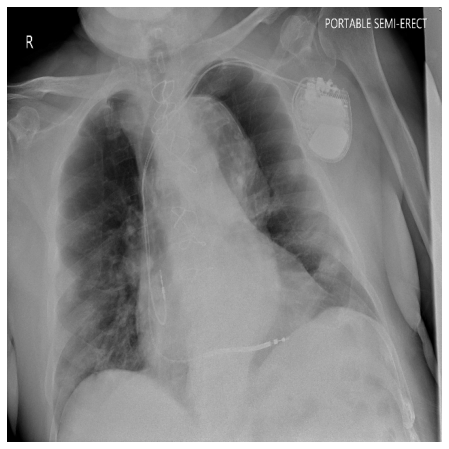

In [17]:
def draw_sample(dataset, idx):
    image, instances = dataset[idx]
    print(image)
    print('image_shape: ',image.shape)
    image = image.permute(1, 2, 0).numpy()
    for k, v in instances.items():
        print(f'{k}: {v}')
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    plt.imshow(image, cmap='gray')
    ax.set_axis_off()
    plt.show()
    

draw_sample(test_dataset, 2)

# Model

## Study level

In [18]:
def load_model_state(net, checkpoint_path, device=device):
    checkpoint = torch.load(checkpoint_path , map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])

In [19]:
class EffnetAux(nn.Module):
    def __init__(self, model_name, num_classes=config['num_classes'], pretrained=False):
        super().__init__()
        eff = model_name(pretrained=pretrained, drop_rate=0.3, drop_path_rate=0.2, in_chans=1)
        self.b0 = nn.Sequential(
            eff.conv_stem,
            eff.bn1,
            eff.act1,
        )
        
        self.b1 = eff.blocks[0]
        self.b2 = eff.blocks[1]
        self.b3 = eff.blocks[2]
        self.b4 = eff.blocks[3]
        self.b5 = eff.blocks[4]
        self.b6 = eff.blocks[5]
        self.b7 = eff.blocks[6]
        self.b8 = nn.Sequential(
            eff.conv_head,
            eff.bn2,
            eff.act2,
        )
        self.logit = nn.Linear(2560, num_classes)
        
        self.mask = nn.Sequential(
            nn.Conv2d(224, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.SiLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.SiLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=1, padding=0),
        )
    
#         self.aux_head = nn.Sequential(
#             nn.Conv2d(224, 1344, kernel_size=(1, 1), stride=(1, 1), bias=False), # effnetb7_ns
#             nn.BatchNorm2d(1344, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
#             nn.SiLU(inplace=True),
#         )
#         self.aux_logit = nn.Linear(1344, num_classes)

    def forward(self, x):
        x = 2 * x - 1
        batch_size = len(x)
        
        x = self.b0(x)
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        #------------
#         aux = self.aux_head(x)
#         aux = F.adaptive_avg_pool2d(aux, 1).reshape(batch_size, -1)
#         aux = self.aux_logit(aux)
        aux = self.mask(x)
        #-------------
        x = self.b6(x)
        x = self.b7(x)
        x = self.b8(x)
        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        #x = F.dropout(x, 0.5, training=self.training)
        logit = self.logit(x)
        return logit, aux

In [20]:
def convert_silu_to_mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.SiLU):
            setattr(model, child_name, nn.Mish(inplace=True))
        else:
            convert_silu_to_mish(child)

## Image level

In [21]:
#yolov5
#detectron2

# Make prediction df

## Study level

In [22]:
def get_tta(number, image):
#     image = image.permute(1, 2, 0).float()
    image = image.float().to(device)
    if number == 0:
        # HFLIP
        augmented = torch.fliplr(image[0])
        
    elif number == 1:
#         # CONTRAST: adjusted = alpha*image + beta
#         alpha = 1.5  # Contrast control (1.0-3.0)
#         beta = 0 # Brightness control (0-100)
#         augmented = (cv2.convertScaleAbs(image * 255.0, alpha=alpha, beta=beta) / 255.0).astype(np.float32) 

        # SCALE
        augmented = F.interpolate(torch.unsqueeze(image, dim=0), scale_factor=1.33, mode='bilinear', align_corners=False)[0][0]
        
    return torch.unsqueeze(augmented, dim=0).to(device)

def prediction_tta(net, images):
    net.eval().to(device)
    seed_everything(config['seed'])
    result_list = []
    
    for image in images:
        image_result_list = []
        
        for i in range(2):
            augmented_image = get_tta(i, image)
            
            with torch.no_grad():
                outputs, aux_out = net(torch.unsqueeze(augmented_image, dim=0))    
            prob = F.softmax(outputs)
            image_result_list.append(prob)
            
        with torch.no_grad():
            orig_outputs, aux_oputs = net(torch.unsqueeze(image, dim=0))
            orig_prob = F.softmax(orig_outputs)
        image_result_list.append(orig_prob)
        
        result_list.append(torch.stack(image_result_list).mean(dim=0)[0])
    
    return torch.stack(result_list)

In [23]:
def make_prediction_study_df(net, loader, fold=None, apply_tta=True):
    if DEBUG_MODE: print('DEBUG_MODE')
    net.to(device)
    net.eval()
    result_list = []
    for images, instances in progress_bar(loader):
        with torch.no_grad():
            images = torch.stack(images) / 255.0
            images = images.to(device)
            batch_num = images.shape[0]
            if apply_tta:
                pred_proba = prediction_tta(net, images)
            else:
                pred, aux_pred = net(images)
                pred_proba = F.softmax(pred)
            for batch_n in range(batch_num):
                pred_dict = {
                    'StudyInstanceUID': instances[batch_n]['study_id'],
                    'ImageInstanceUID': instances[batch_n]['image_id'],
                    'negative': pred_proba[batch_n, 0].item(),
                    'typical': pred_proba[batch_n, 1].item(),
                    'indeterminate': pred_proba[batch_n, 2].item(),
                    'atypical': pred_proba[batch_n, 3].item(),
                }
                
                if fold + 1:
                    pred_dict['fold'] = int(fold)
                result_list.append(pred_dict)
        if DEBUG_MODE: break
    study_df = pd.DataFrame(result_list)
    study_df[['negative', 'typical', 'indeterminate', 'atypical']] = study_df[['negative', 'typical', 'indeterminate', 'atypical']].astype(np.float32)
    gc.collect()
    return study_df

def make_prediction_study_cv_df(net, loader, checkpoint_path_list, apply_tta=True):
    study_cv_df = pd.DataFrame()
    for fold, checkpoint_path in enumerate(checkpoint_path_list):
        load_model_state(net, checkpoint_path)
        pred_fold_df = make_prediction_study_df(net, loader, fold=fold, apply_tta=apply_tta)
        study_cv_df = study_cv_df.append(pred_fold_df)
    return study_cv_df

def average_study_cv(df):
    df = df.groupby(['StudyInstanceUID', 'ImageInstanceUID'])[['negative', 'typical', 'indeterminate', 'atypical']].mean()
    return df.reset_index()

In [24]:
#study net
if sub_study:
    print('ON STUDY STEP')
    if config['aux_loss']:
        study_net_effnet = EffnetAux(model_name=config['effnet_model_name'])
        if torch.__version__ == '1.9.0+cu102':
            convert_silu_to_mish(study_net_effnet)
            print('Converted to Mish')
    else:
        study_net_effnet = Effnet(model_name=config['effnet_model_name'])
        
    config['image_size'] = 640
    if DEBUG_MODE: config['batch_size'] = 2
    
    test_dataset = get_test_dataset(test_df)
    test_loader = get_test_loader(test_dataset)
    
    pred_study_df = make_prediction_study_cv_df(study_net_effnet, test_loader, effnet_checkpoint_path_list, apply_tta=True)
    pred_study_cv_df = average_study_cv(pred_study_df)

ON STUDY STEP
Converted to Mish


In [25]:
# study_net_swint = SwinTransformer(model_name='swin_base_patch4_window12_384')
# config['image_size'] = 384

# pred_study_df_swint = make_prediction_study_cv_df(study_net_swint, test_loader_tta, swint_checkpoint_path_list)
# pred_study_cv_df_swint = average_study_cv(pred_study_df_swint)

In [26]:
if sub_study:
    display(pred_study_df)

,StudyInstanceUID,ImageInstanceUID,negative,typical,indeterminate,atypical,fold
0,2fb11712bc93,a29c5a68b07b,0.004075,0.917470,0.065945,0.012510,0
1,19c66935e737,9850b5470fd6,0.024180,0.693709,0.204872,0.077240,0
2,2fc50bf199cd,8d6dea06a032,0.050294,0.675277,0.211886,0.062543,0
3,97c5d6eb413d,dfc5c09a50bc,0.076478,0.466063,0.268367,0.189091,0
4,593c3f815635,7230234e120a,0.010663,0.553530,0.208990,0.226818,0
...,...,...,...,...,...,...,...
1258,b12d2e5c39b7,a43200bd5ceb,0.091246,0.648925,0.209776,0.050053,4
1259,6484393291ea,37bf83df1b86,0.001676,0.949411,0.043380,0.005533,4
1260,6484393291ea,b30d2aef985f,0.001905,0.941873,0.049615,0.006606,4
1261,531aa20ff7c3,a37a362df0ac,0.691205,0.194457,0.098838,0.015500,4


In [27]:
if sub_study:
    display(pred_study_cv_df)

,StudyInstanceUID,ImageInstanceUID,negative,typical,indeterminate,atypical
0,00188a671292,3dcdfc352a06,0.832956,0.049219,0.091810,0.026015
1,004bd59708be,c39146cbda47,0.009502,0.860318,0.108172,0.022009
2,00508faccd39,951211f8e1bb,0.602439,0.176720,0.174914,0.045928
3,006486aa80b2,5e0e7acd9c7d,0.281691,0.257965,0.277554,0.182790
4,00655178fdfc,5b8ee5baa1d5,0.382822,0.291597,0.260856,0.064726
...,...,...,...,...,...,...
1258,ff1ba0e9aaf0,064b37b01cd2,0.187788,0.519334,0.244494,0.048385
1259,ff2cc4de58c5,02eceb0fc405,0.152953,0.165678,0.436800,0.244569
1260,ff2f0a744930,16a0d37747d7,0.004218,0.926708,0.058807,0.010267
1261,ff88940dce8b,aa55fc6c616c,0.595066,0.208814,0.161723,0.034397


In [28]:
if sub_study:
    display(pred_study_cv_df.describe())

,negative,typical,indeterminate,atypical
count,1263.000000,1263.000000,1263.000000,1263.000000
mean,0.280820,0.478223,0.169760,0.071197
std,0.319728,0.314820,0.092313,0.099661
min,0.000557,0.006053,0.024326,0.003239
25%,0.017770,0.183739,0.088307,0.018704
50%,0.115284,0.472828,0.158835,0.039615
75%,0.515672,0.794095,0.240077,0.081518
max,0.961765,0.969352,0.493662,0.869936


## Image level

In [29]:
# test_df

In [30]:
def dicom2array(path, voi_lut=True, fix_monochrome=True): # dicom
    dicom = pydicom.dcmread(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [31]:
# images, instances = next(iter(test_loader))
# cfg = get_cfg()
# config_name = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
# cfg.merge_from_file(model_zoo.get_config_file(config_name))
# cfg.MODEL.WEIGHTS = detectron2_checkpoint_path_list[0]
# cfg.MODEL.DEVICE = 'cpu'
# predictor = DefaultPredictor(cfg)
# predictions = predict_batch(predictor, images)

In [32]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.data import detection_utils as utils

In [33]:
sys.path.append('../input/centernet2/projects/CenterNet2')
from centernet.config import add_centernet_config
config_file = '../input/centernet2/projects/CenterNet2/configs/CenterNet2_R2-101-DCN-BiFPN_4x+4x_1560_ST.yaml'
# config_file = '../input/centernet2/projects/CenterNet2/configs/CenterNet2_R2-101-DCN_896_4x.yaml'
cfg = get_cfg()
add_centernet_config(cfg)
cfg.merge_from_file(config_file)
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 8
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
# cfg = get_cfg()
# config_name = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
# cfg.merge_from_file(model_zoo.get_config_file(config_name))

In [34]:
# if not DEBUG_MODE:
#     sys.path.append('../input/centernet2/projects/CenterNet2')
#     from centernet.config import add_centernet_config
#     config_file = '../input/centernet2/projects/CenterNet2/configs/CenterNet2_R2-101-DCN-BiFPN_4x+4x_1560_ST.yaml'
#     cfg = get_cfg()
#     add_centernet_config(cfg)
#     cfg.merge_from_file(config_file)
# else:
#     cfg = get_cfg()
#     config_name = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
#     cfg.merge_from_file(model_zoo.get_config_file(config_name))


# visualize
# tt = pred_image_df_detectron2[pred_image_df_detectron2['ImageInstanceUID'] == 'a29c5a68b07b'].copy()
# tt[['x_min', 'x_max']] *= 2828
# tt[['y_min', 'y_max']] *= 2320


# image_ins_unique = tt['ImageInstanceUID'].unique()
# sample = 5
# if DEBUG_MODE: sample = 1
# for image_id in np.random.choice(image_ins_unique, 1, replace=False):
# #       vitualize(pred_image_cv_df, image_id, info=pred_study_cv_df)
#     vitualize(tt, image_id, info=pd.DataFrame())

In [35]:
def predict_batch(predictor, im_list):
    with torch.no_grad():
        inputs_list = []
        for original_image in im_list:
            image = original_image[0]
            image = torch.stack([image, image, image], axis=0)
            inputs = {'image': image, 'height': config['image_size'], 'width': config['image_size']}
            inputs_list.append(inputs)
        predictions = predictor.model(inputs_list)
        return predictions

In [36]:
def make_prediction_image_df_detectron2(cfg, loader, weight_list=None, conf=0.001):
#     if DEBUG_MODE:
#         print('DEBUG_MODE')
#         cfg.MODEL.DEVICE = 'cpu'
#     else:
#         cfg.MODEL.DEVICE = 'cuda'
#     cfg.MODEL.DEVICE = 'cuda' 
#     ensem_boxes = []
#     ensem_scores = []
    result_list = []
    
    for fold, weight in enumerate(weight_list):
        print(weight)
        # temporary code
        cfg.MODEL.WEIGHTS = weight
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = conf
        
        predictor = DefaultPredictor(cfg)
#         step = 0 
        for images, instances in progress_bar(loader):
#             step += 1
            predictions = predict_batch(predictor, images)
            for image_num ,prediction in enumerate(predictions):
                # indiv
                fields = prediction['instances'].get_fields()
                boxes = fields['pred_boxes'].tensor / (config['image_size'] - 1)
                scores = fields['scores']
                labels = torch.ones_like(scores)
                
#                 ensem_boxes.append(boxes.tolist())
#                 ensem_scores.append(scores.tolist())
                
                if DEBUG_MODE: break
                boxes, scores, labels = weighted_boxes_fusion([boxes.tolist()], [scores.tolist()], [labels.tolist()], weights=None, iou_thr=0.6, skip_box_thr=0.0)
#                 boxes, scores, labels = nms([boxes.tolist()], [scores.tolist()], [labels.tolist()], weights=None, iou_thr=0.5)
                item_size = len(boxes)          
                
                for box, score in zip(boxes, scores):
                    image_dict = {
                        'ImageInstanceUID': instances[image_num]['image_id'],
                        'opacity': 'opacity',
                        'conf': score.item(),
                        'x_min': box[0].item(),
                        'y_min': box[1].item(),
                        'x_max': box[2].item(),
                        'y_max': box[3].item(),
                        'width': instances[image_num]['width'],
                        'height': instances[image_num]['height'],
                        'fold': fold,
                    }
                    result_list.append(image_dict)
#             if step == 1:
#                 break
    image_df = pd.DataFrame(result_list)
    return image_df.reset_index(drop=True)

In [37]:
detectron2_checkpoint_path_list

['../input/detectron2-model/centernet2/centernet2/DCN-r2-101-BiFPN/model_final_f4_centernet2_BiFPN_Haug.pth']

In [38]:
if sub_image:
    print('ON IMAGE STEP DETECTRON2')
    config['image_size'] = 640
    
    test_dataset = get_test_dataset(test_df)
    pred_image_df_detectron2 = make_prediction_image_df_detectron2(cfg, test_loader, detectron2_checkpoint_path_list, conf=0.001)

ON IMAGE STEP DETECTRON2
../input/detectron2-model/centernet2/centernet2/DCN-r2-101-BiFPN/model_final_f4_centernet2_BiFPN_Haug.pth


In [39]:
if sub_image:
    display(pred_image_df_detectron2)

,ImageInstanceUID,opacity,conf,x_min,y_min,x_max,y_max,width,height,fold
0,a29c5a68b07b,opacity,0.616125,0.658109,0.234954,0.962210,0.801457,2320,2828,0
1,a29c5a68b07b,opacity,0.370576,0.219638,0.266930,0.529413,0.809638,2320,2828,0
2,a29c5a68b07b,opacity,0.291007,0.696631,0.312316,0.938408,0.731471,2320,2828,0
3,a29c5a68b07b,opacity,0.198957,0.222007,0.366130,0.436353,0.773920,2320,2828,0
4,a29c5a68b07b,opacity,0.121331,0.259800,0.276686,0.492031,0.686810,2320,2828,0
...,...,...,...,...,...,...,...,...,...,...
28524,a0f473f71878,opacity,0.046753,0.862536,0.138537,0.980850,0.304001,2320,2832,0
28525,a0f473f71878,opacity,0.043934,0.343447,0.105347,0.453552,0.291694,2320,2832,0
28526,a0f473f71878,opacity,0.042115,0.794902,0.140397,0.916315,0.297360,2320,2832,0
28527,a0f473f71878,opacity,0.040934,0.338514,0.148640,0.451144,0.342668,2320,2832,0


In [40]:
if sub_image:
    display(pred_image_df_detectron2.describe())

,conf,x_min,y_min,x_max,y_max,width,height,fold
count,28529.000000,28529.000000,28529.000000,28529.000000,28529.000000,28529.000000,28529.000000,28529.0
mean,0.094589,0.412864,0.382900,0.601318,0.651470,2678.572680,3096.945354,0.0
std,0.088136,0.240293,0.160102,0.238934,0.160465,578.435521,688.758940,0.0
min,0.005413,0.000045,0.000000,0.015234,0.022418,1140.000000,1140.000000,0.0
25%,0.039150,0.184367,0.258046,0.376799,0.546972,2336.000000,2832.000000,0.0
50%,0.064626,0.369426,0.385741,0.583502,0.672842,2544.000000,3001.000000,0.0
75%,0.113047,0.642084,0.504720,0.832105,0.766425,3032.000000,3278.000000,0.0
max,0.700415,0.990291,0.995278,1.000000,1.000000,4248.000000,4891.000000,0.0


In [41]:
# tt = pred_image_df_detectron2[pred_image_df_detectron2['ImageInstanceUID'] == '5a0de0207028'].copy()
# tt[['x_min','x_max']] *= 4240
# tt[['y_min','y_max']] *= 3480

# image_ins_unique = tt['ImageInstanceUID'].unique()
# sample = 5
# if DEBUG_MODE: sample = 1
# for image_id in np.random.choice(image_ins_unique, 1, replace=False):
#     vitualize(tt, image_id, info=pd.DataFrame())

In [42]:
# iter_dataset = iter(test_dataset)

In [43]:
# from utils.general import non_max_suppression, xywh2xyxy

# # debugger
# net = torch.load(yolov5_checkpoint_path_list[1], map_location=device)['model'].float()
# net.eval()
# image, inst = next(iter_dataset)
# image = torch.stack([image, image, image], axis=-1)
# image = image.permute(0, 3, 1, 2).float()
# image /= 255.0

# pred = net(image ,augment=True)[0]
# dets = non_max_suppression(pred, 0.002, 0.5, classes=None, agnostic=False)

# labels = dets[0][:, 5]
# scores = dets[0][:, 4]
# bboxes = dets[0][:, :4] / (640 - 1)
# boxes, scores, labels = weighted_boxes_fusion([bboxes], [scores], [labels], weights=None, iou_thr=0.5, skip_box_thr=0.0)
# item_size = len(boxes)
# dets_wbf = np.concatenate([labels.reshape(item_size, 1),
#                         scores.reshape(item_size, 1),
#                         boxes * (640 - 1)], axis=1)

In [44]:
# sys.path.remove('../input/yetanotherefficientdetpytorch')
sys.path.append('../input/offline-yolov5')

from utils.general import non_max_suppression, xywh2xyxy
from models.experimental import attempt_load

def detect_one_image(net, image, height, width, conf_thres, skip_box_thr=config['skip_box_thr'], iou_thres=config['iou_thres'], aug=True):
    net.eval()
    net.to(device)
    image = image.to(device)
    with torch.no_grad():
        pred = net(image, augment=aug)[0]
        dets = non_max_suppression(pred, conf_thres=conf_thres, iou_thres=iou_thres, classes=None, agnostic=False)
        dets = torch.stack(dets).tolist()
    return dets

def make_prediction_image_df(dataset, weights, conf_thres, default_predictor=False, fold=None):
    if DEBUG_MODE: print('DEBUG_MODE')
    result_list = []
    if default_predictor:
        # ensemble model with default from repo
        # take list of weights to ensemble
        net = attempt_load(weights, map_location=device)
    else:
        net = torch.load(weights, map_location=device)['model'].float()
        
    for image, instances in progress_bar(dataset):
        image_id = instances['image_id']
        idx = instances['idx']
        height = instances['height']
        width = instances['width']
        
        image = torch.stack([image, image, image], axis=-1)
        image = image.permute(0, 3, 1, 2).float()
        image /= 255.0
        image.to(device)
        dets = detect_one_image(net, image, height, width, conf_thres=conf_thres)
        
        if dets[0]:
            for det in dets[0]:
                conf = det[4]
                bboxes = np.array(det[:4]) / (config['image_size'] - 1)
                pred_dict = {
                    'ImageInstanceUID': image_id,
                    'opacity': 'opacity',
                    'conf': conf,
                    'x_min': bboxes[0],
                    'y_min': bboxes[1],
                    'x_max': bboxes[2],
                    'y_max': bboxes[3],
                    'width': width,
                    'height': height
                }
                result_list.append(pred_dict)
                
        elif not dets[0]:
            pred_dict = {
                'ImageInstanceUID': image_id,
                'opacity': 'none',
                'conf': 1,
                'x_min': 0,
                'y_min': 0,
                'x_max': 1,
                'y_max': 1,
                'width': width,
                'height': height
            }
            result_list.append(pred_dict)
    
        if fold: image_df['fold'] = int(fold)
        if DEBUG_MODE: break
            
    image_df = pd.DataFrame(result_list)
    return image_df.reset_index(drop=True)

In [45]:
def make_prediction_image_cv(dataset, checkpoint_path_list, conf_thres_list, default_predictor=False):
    image_cv_df = pd.DataFrame()
    if not default_predictor:
        for fold, (checkpoint_path, conf_thres) in enumerate(zip(checkpoint_path_list, conf_thres_list)):
            pred_fold_df = make_prediction_image_df(dataset, checkpoint_path, conf_thres, default_predictor, fold)
            image_cv_df = image_cv_df.append(pred_fold_df)
    else:
        for model_num, (checkpoint_list, conf_thres) in enumerate(zip(checkpoint_path_list, conf_thres_list)):
            pred_fold_df = make_prediction_image_df(dataset, checkpoint_list, conf_thres[0], default_predictor, fold=model_num)
            image_cv_df = image_cv_df.append(pred_fold_df)
    return image_cv_df

In [46]:
if sub_image:
    print('ON IMAGE STEP YOLOV5')
    config['image_size'] = 640
    # 832 
    test_dataset = get_test_dataset(test_df)
    
    pred_image_df_yolov5 = make_prediction_image_cv(test_dataset, yolov5_checkpoint_path_list, conf_thres_list, default_predictor=True)
    display(pred_image_df_yolov5)

ON IMAGE STEP YOLOV5
Ensemble created with ['../input/offlinemodeldependency/yolov5m6_neg_640px/yolov5m6_neg_640px/f0_yolov5m6_neg_640px-best.pt', '../input/offlinemodeldependency/yolov5m6_neg_640px/yolov5m6_neg_640px/f1_yolov5m6_neg_640px-best.pt', '../input/offlinemodeldependency/yolov5m6_neg_640px/yolov5m6_neg_640px/f2_yolov5m6_neg_640px-best.pt', '../input/offlinemodeldependency/yolov5m6_neg_640px/yolov5m6_neg_640px/f3_yolov5m6_neg_640px-best.pt', '../input/offlinemodeldependency/yolov5m6_neg_640px/yolov5m6_neg_640px/f4_yolov5m6_neg_640px-best.pt']



,ImageInstanceUID,opacity,conf,x_min,y_min,x_max,y_max,width,height
0,a29c5a68b07b,opacity,0.658131,0.657969,0.309836,0.973292,0.803054,2320,2828
1,a29c5a68b07b,opacity,0.617706,0.206611,0.309578,0.520211,0.810105,2320,2828
2,a29c5a68b07b,opacity,0.054430,0.146085,0.184298,0.599802,0.880186,2320,2828
3,a29c5a68b07b,opacity,0.044407,0.569711,0.163246,1.021213,0.863332,2320,2828
4,a29c5a68b07b,opacity,0.030961,0.200840,0.606605,0.473717,0.834968,2320,2828
...,...,...,...,...,...,...,...,...,...
101159,a0f473f71878,opacity,0.001065,0.777405,0.099276,0.884384,0.218937,2320,2832
101160,a0f473f71878,opacity,0.001061,0.658742,0.360395,0.952781,0.570943,2320,2832
101161,a0f473f71878,opacity,0.001034,-0.248443,-0.205562,0.347651,0.545707,2320,2832
101162,a0f473f71878,opacity,0.001021,0.409186,0.262049,0.546988,0.397162,2320,2832


In [47]:
if sub_image:
    display(pred_image_df_yolov5.describe())

,conf,x_min,y_min,x_max,y_max,width,height
count,101164.000000,101164.000000,101164.000000,101164.000000,101164.000000,101164.000000,101164.000000
mean,0.019111,0.384716,0.344147,0.623364,0.641050,2659.873097,3088.618906
std,0.068762,0.288226,0.238178,0.280170,0.236498,580.532367,690.775403
min,0.001000,-1.071345,-0.794856,-0.032394,0.024694,1140.000000,1140.000000
25%,0.001430,0.160243,0.191121,0.377932,0.471443,2336.000000,2832.000000
50%,0.002585,0.328202,0.346475,0.666179,0.650648,2544.000000,3000.000000
75%,0.007722,0.636322,0.518719,0.851150,0.788295,3000.000000,3256.000000
max,0.772598,1.000704,0.979182,1.880168,1.927235,4248.000000,4891.000000


# Ensemble Bounding boxes

In [48]:
def ensemble_image_cv(df, weights=None, method='wbf', iou_thr=config['iou_thres'], skip_box_thr=config['skip_box_thr']):
    ensembled_image_cv_df = pd.DataFrame()
    
    for image_id in df['ImageInstanceUID'].unique():
        ensem_scores = []
        ensem_boxes = []

        scores_list = []
        boxes_list = []
        labels_list = []

        indiv_df = df[df['ImageInstanceUID'] == image_id]
        
        width, height = indiv_df['width'].values[0], indiv_df['height'].values[0]
        opacity_list = indiv_df['opacity'].tolist()
        
        if 'none' in opacity_list:
            opacity = 'none'
        else:
            opacity = 'opacity'
        
        scores = indiv_df['conf'].values.tolist()
        boxes = indiv_df[['x_min', 'y_min', 'x_max', 'y_max']].values.tolist()
        labels = [1] * len(scores)

        scores_list.append(scores)
        boxes_list.append(boxes)
        labels_list.append(labels)
        
        # run wbf
        # always apply when pred more than one model
        if method == 'wbf':
            boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
        elif method == 'nms':
            boxes, scores, labels = nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr)

        ensem_scores.append(scores.tolist())
        ensem_boxes.append(boxes.tolist())
        
        # concate scores and bboxes
        con_ensem_scores = np.concatenate(ensem_scores)
        item_size = len(con_ensem_scores)
        con_ensem_scores = con_ensem_scores.reshape(item_size, 1)
        con_ensem_boxes = np.concatenate(ensem_boxes)
        try:
            ensembled = np.concatenate([con_ensem_scores, con_ensem_boxes], axis=1)
        except ValueError:
            opacity = 'none'
        if opacity == 'opacity':
            ensem_dict = {
                'ImageInstanceUID': [image_id] * item_size,
                'opacity': 'opacity',
                'conf': ensembled[:, 0].tolist(),
                'x_min': (ensembled[:, 1] * height).tolist(),
                'y_min': (ensembled[:, 2] * width).tolist(),
                'x_max': (ensembled[:, 3] * height).tolist(),
                'y_max': (ensembled[:, 4] * width).tolist(),
                'widht': [width] * item_size,
                'height': [height] * item_size,
            }
        elif opacity == 'none':
            ensem_dict = {
                'ImageInstanceUID': [image_id] * item_size,
                'opacity': 'none',
                'conf': 1.0,
                'x_min': 0.0,
                'y_min': 0.0,
                'x_max': 1.0,
                'y_max': 1.0,
                'width': [width] * item_size,
                'height': [height] * item_size,
            }
        
        # create ensembled individual df
        ensem_indiv_df = pd.DataFrame(ensem_dict, index=range(item_size))
        
#         # drop big box
#         drop_bigbox_list = []
#         for col, size in zip(['x_max', 'y_max'], [height, width]):
#             drop_bigbox_list.append(ensem_indiv_df.loc[ensem_indiv_df[col] == size].index.values)
#         if drop_bigbox_list:
#             drop_bigbox_list = list(set(np.concatenate(drop_bigbox_list)))
#             ensem_indiv_df = ensem_indiv_df.drop(drop_bigbox_list)
        
        # add to man df
        ensembled_image_cv_df = ensembled_image_cv_df.append(ensem_indiv_df)
    
    return ensembled_image_cv_df.drop_duplicates().reset_index(drop=True)

In [49]:
if sub_image:
    print('ENSEMBLING BOXES')
    pred_image_df_all = pred_image_df_yolov5.append(pred_image_df_detectron2)
    pred_image_cv_df = ensemble_image_cv(pred_image_df_all, method=config['ensemble_method'])
#     pred_image_cv_df = ensemble_image_cv(pred_image_df_yolov5, method=config['ensemble_method'])
    
# #     # drop 0
#     drop_list = []
#     for col in ['x_min', 'y_min', 'x_max', 'y_max']:
#         drop_list.append(pred_image_cv_df.loc[pred_image_cv_df[col] == 0].index.values)
#     drop_list = list(set(np.concatenate(drop_list)))
#     pred_image_cv_df = pred_image_cv_df.drop(drop_list).reset_index(drop=True)
    
    display(pred_image_cv_df)

ENSEMBLING BOXES


,ImageInstanceUID,opacity,conf,x_min,y_min,x_max,y_max,widht,height
0,a29c5a68b07b,opacity,0.328709,1883.491682,666.696041,2720.175987,1832.072821,2320,2828
1,a29c5a68b07b,opacity,0.233873,629.119919,709.002550,1435.043441,1828.392701,2320,2828
2,a29c5a68b07b,opacity,0.054430,413.129584,427.572344,1696.239337,2042.031479,2320,2828
3,a29c5a68b07b,opacity,0.050678,2075.990086,821.891491,2559.015774,1422.836699,2320,2828
4,a29c5a68b07b,opacity,0.044407,1611.141311,378.730719,2828.000000,2002.930391,2320,2828
...,...,...,...,...,...,...,...,...,...
80097,a0f473f71878,opacity,0.001065,2201.610352,230.319733,2504.576672,507.934555,2320,2832
80098,a0f473f71878,opacity,0.001061,1865.556888,836.116508,2698.274565,1324.588659,2320,2832
80099,a0f473f71878,opacity,0.001034,0.000000,0.000000,984.547893,1266.041067,2320,2832
80100,a0f473f71878,opacity,0.001021,1158.816081,607.953290,1549.070817,921.416159,2320,2832


In [50]:
if sub_image:
    display(pred_image_cv_df.describe())

,conf,x_min,y_min,x_max,y_max,widht,height
count,80102.000000,80102.000000,80102.000000,80102.000000,80102.000000,80102.000000,80102.000000
mean,0.017853,1231.758092,938.248089,1887.977911,1657.151130,2662.286048,3089.307408
std,0.044264,895.981722,619.293263,941.127277,701.102860,577.245858,686.033805
min,0.001000,0.000000,0.000000,0.296023,29.701213,1140.000000,1140.000000
25%,0.001454,489.546435,472.422988,1110.858284,1132.380313,2336.000000,2832.000000
50%,0.002837,1016.679292,878.375897,1842.757502,1644.545512,2544.000000,3000.000000
75%,0.014719,1926.632497,1356.697752,2562.351660,2111.759138,3000.000000,3200.000000
max,0.697299,4778.560560,4077.531436,4891.000000,4248.000000,4248.000000,4891.000000


In [51]:
def vitualize(pred_image_df, image_id, info=pd.DataFrame()):
    path = glob(f'{TEST_PATH}/*/*/{image_id}.dcm')[0]
    dicom_image = dicom2array(path)
    image = np.array(dicom_image)
    bboxes = pred_image_df[pred_image_df['ImageInstanceUID'] == image_id][['x_min', 'y_min', 'x_max', 'y_max']].values
    confs = pred_image_df[pred_image_df['ImageInstanceUID'] == image_id]['conf'].values
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for bbox, conf in zip(bboxes, confs):
        start = (int(bbox[0]), int(bbox[1]))
        end = (int(bbox[2]), int(bbox[3]))
        color = (255, 0, 0)
        cv2.rectangle(image, start ,end, color, 3)
        cv2.putText(image, str(round(conf, 3)), (start[0], start[1]-40), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 3)
    
    plt.imshow(image)
#     ax.set_axis_off()
    if not info.empty:
        UID, proba = get_info(info, image_id)
        plt.title(
            'ImageInstanceUID : {}\n'.format(UID[0]) + \
            'StudyInstanceUID : {}\n'.format(UID[1]) + \
            'negative         : {}\n'.format(proba[0]) + \
            'typical          : {}\n'.format(proba[1]) + \
            'indeterminate    : {}\n'.format(proba[2]) + \
            'atypical         : {}\n'.format(proba[3]),
            loc='left'
        )
    else:
        plt.title(image_id)
    plt.show()
    
def get_info(pred_study_df, image_id):
    proba = pred_study_df[pred_study_df['ImageInstanceUID'] == image_id][['StudyInstanceUID', 'negative', 'typical', 'indeterminate', 'atypical']]
    return [image_id, proba['StudyInstanceUID'].iloc[0]], [proba['negative'].iloc[0], proba['typical'].iloc[0], proba['indeterminate'].iloc[0], proba['atypical'].iloc[0]]

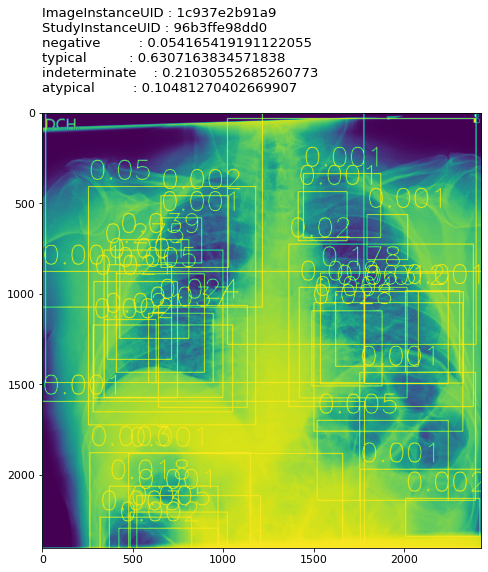

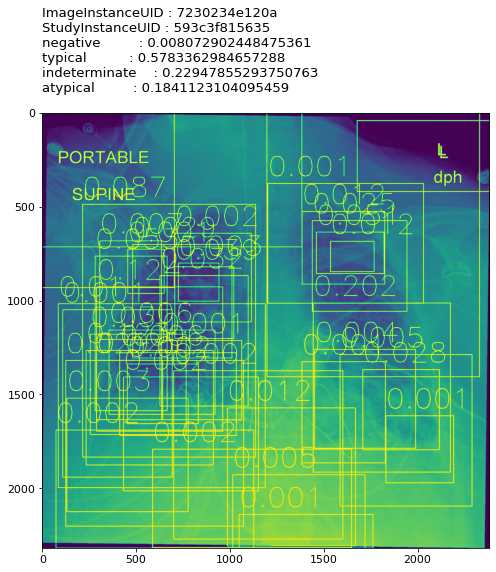

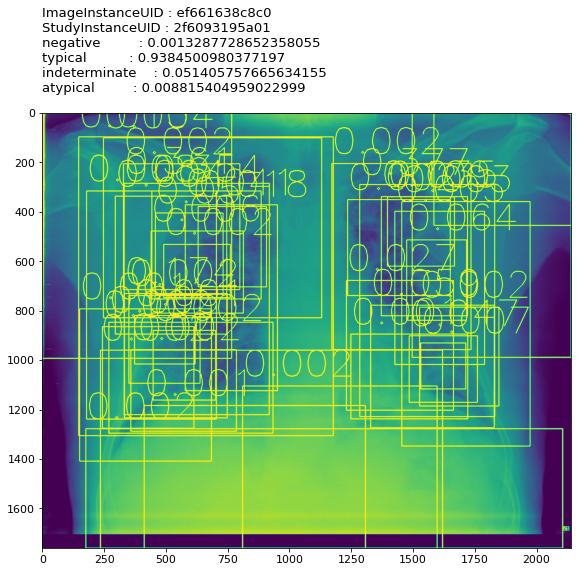

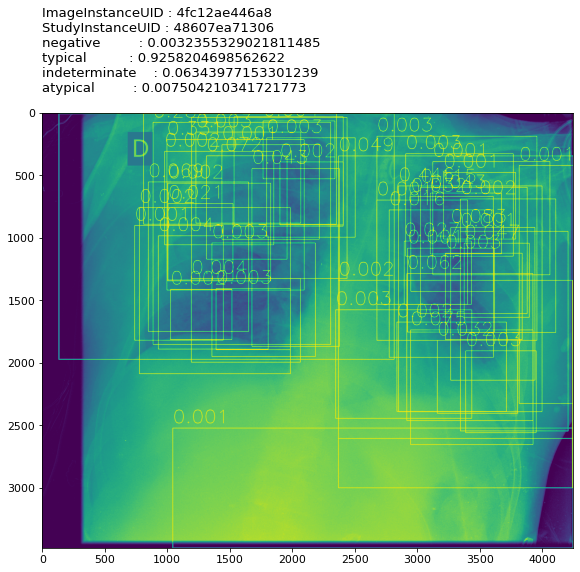

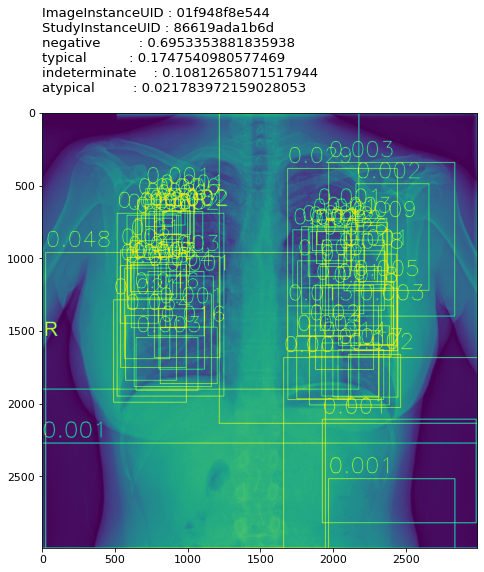

In [52]:
if sub_study and sub_image:
    image_ins_unique = pred_image_cv_df['ImageInstanceUID'].unique()
    sample = 5
    if DEBUG_MODE: sample = 1
    for image_id in np.random.choice(image_ins_unique, sample, replace=False):
        vitualize(pred_image_cv_df, image_id, info=pred_study_cv_df)
#         vitualize(pred_image_cv_df, image_id, info=pd.DataFrame())

# Make Submission

In [53]:
def make_sub(test_df, pred_study_df=None, pred_image_df=None, task_list=[], apply_neg=True):
    pred_df = pd.DataFrame()
    
    raw_study_df = test_df['StudyInstanceUID'].apply(lambda row: row + '_study').rename('id')
    raw_study_df = pd.concat([raw_study_df, pd.Series([''] * len(raw_study_df), name='PredictionString')], axis=1).drop_duplicates('id')
    
    raw_image_df = test_df['ImageInstanceUID'].apply(lambda row: row + '_image').rename('id')
    raw_image_df = pd.concat([raw_image_df, pd.Series([''] * len(raw_image_df), name='PredictionString')], axis=1)
    
    if 'study' in task_list:
        # averaging same study_id with multiple image_id
#         pred_study_cv_df_mean = pred_study_cv_df.groupby('study_id')[['negative', 'typical', 'indeterminate', 'atypical']].mean().reset_index()
        pred_study_df = pred_study_df.drop_duplicates('StudyInstanceUID').reset_index(drop=True)
        for idx, row in pred_study_df.iterrows():
            study_dict = {
                'id': row['StudyInstanceUID'] + '_study',
                'PredictionString': f'negative {row.negative} 0 0 1 1 ' + \
                                    f'typical {row.typical} 0 0 1 1 ' + \
                                    f'indeterminate {row.indeterminate} 0 0 1 1 ' + \
                                    f'atypical {row.atypical} 0 0 1 1',
            }
            pred_df = pred_df.append(pd.DataFrame(study_dict, index=[idx]), ignore_index=True)

    if 'image' in task_list:
        pred_image_df[['x_min', 'y_min', 'x_max','y_max']] = pred_image_df[['x_min', 'y_min', 'x_max','y_max']].round()
        for image_uid in pred_image_df['ImageInstanceUID'].unique():
            image_dict = {
                'id': image_uid + '_image',
                'PredictionString': ''
            }
            
            for idx, box_info in enumerate(pred_image_df[pred_image_df['ImageInstanceUID'] == image_uid][['opacity','conf', 'x_min', 'y_min', 'x_max', 'y_max']].values):
                image_dict['PredictionString'] += f'{box_info[0]} {box_info[1]} {box_info[2]} {box_info[3]} {box_info[4]} {box_info[5]} '
                
            image_dict['PredictionString'] = image_dict['PredictionString'][:-1]
            pred_df = pred_df.append(pd.DataFrame(image_dict, index=[idx]), ignore_index=True)
            
    if 'study' in task_list and 'image' in task_list:
        pred_study_df['argmax'] = np.argmax(pred_study_df[[ 'negative', 'typical', 'indeterminate', 'atypical']].values, axis=1)
        negative_image = pred_study_df[pred_study_df['argmax'] == 0]['ImageInstanceUID']
        pred_df['PredictionString'].iloc[pred_df[pred_df['id'].isin(negative_image.apply(lambda row: row + '_image'))].index] = 'none 1.0 0.0 0.0 1.0 1.0'
        
        if apply_neg:
            for idx, (image, neg) in pred_study_df[pred_study_df['ImageInstanceUID'].isin(negative_image)][['ImageInstanceUID', 'negative']].iterrows():
                pred_df[pred_df['id'] == (image + '_image')] = pred_df[pred_df['id'] == (image + '_image')].replace('none 1.0 0.0 0.0 1.0 1.0', f'none {neg} 0.0 0.0 1.0 1.0')
    
    if 'image' not in task_list:
        pred_df = pd.concat([pred_df, raw_image_df], axis=0)
    
    if 'study' not in task_list:
        pred_df = pd.concat([raw_study_df, pred_df], axis=0)
    
    return pred_df.drop_duplicates('id').reset_index(drop=True)

In [54]:
if sub_study and sub_image:
    print('MAKING SUB DF')
    sub_df = make_sub(test_df, pred_study_cv_df, pred_image_cv_df, task_list=['study', 'image'], apply_neg=True)
    
elif sub_study and not sub_image:
    print('MAKING SUB DF')
    pb_image_cv_df = pd.DataFrame()
    sub_df = make_sub(test_df, pred_study_cv_df, pb_image_cv_df, task_list=['study'])
    
elif not sub_study and sub_image:
    print('MAKING SUB DF')
    pb_study_cv_df = pd.DataFrame()
    sub_df = make_sub(test_df, pb_study_cv_df, pred_image_cv_df, task_list=['image'])

# pb_study_cv_df = pd.DataFrame()
# sub_df = make_sub(test_df, pb_study_cv_df, pred_image_df_detectron2, task_list=['image'])


sub_df.to_csv('submission.csv', index=False)

MAKING SUB DF


In [55]:
display(sub_df)

,id,PredictionString
0,00188a671292_study,negative 0.8329561948776245 0 0 1 1 typical 0....
1,004bd59708be_study,negative 0.00950197596102953 0 0 1 1 typical 0...
2,00508faccd39_study,negative 0.6024385094642639 0 0 1 1 typical 0....
3,006486aa80b2_study,negative 0.2816912829875946 0 0 1 1 typical 0....
4,00655178fdfc_study,negative 0.3828216791152954 0 0 1 1 typical 0....
...,...,...
2472,a43200bd5ceb_image,opacity 0.34063470363616943 583.0 223.0 1309.0...
2473,37bf83df1b86_image,opacity 0.256558895111084 529.0 1035.0 1497.0 ...
2474,b30d2aef985f_image,opacity 0.3546750843524933 2813.0 1073.0 3734....
2475,a37a362df0ac_image,none 0.6617059707641602 0.0 0.0 1.0 1.0
